## Optimization

We developed two methodes for optimization. We used both k-means and GMM to find the best locations for police stations.

In [5]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import ndimage
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import random
import math
import time
import pymc as pm
from sklearn import preprocessing
from scipy.stats import multivariate_normal

from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn import cluster

import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

**Read Dataset**

In [2]:
new_data = pd.read_pickle('Data_Subset_5000_Year2013')
X = list(new_data[0])
Y = list(new_data[1])

new_data2 = pd.read_pickle('Data_Subset_5000_Year2014')
sampled_data = np.load('5000_MH_Samples.npy')

**Define EM Algorithm**

In [37]:
# Initilize the parameters by K-means
def initmu(X, n):
    mus = cluster.KMeans(n_clusters=n).fit(X).cluster_centers_
    return mus
# Calculate resposibility for each datapoint
def E_step(X, mus, sigma, ws):
    r = np.zeros([X.shape[0], mus.shape[0]])
    # get the likelihood
    for j in xrange(len(mus)):
        r[:, j] = ws[j] * multivariate_normal.pdf(X, mus[j, ], sigma)
    # get the proportion
    r = r / r.sum(axis=1)[:, np.newaxis]
    return r

# Maximize posterior distribution
def M_step(X, rs):
    # get the weight for each cluster by summing up samples
    weights = rs.sum(axis=0)
    weighted_X_sum = np.dot(rs.T, X)
    inverse_weights = 1.0 / (weights[:, np.newaxis])
    ws = weights / weights.sum()
    # use sample mean as cluster mean
    mus = weighted_X_sum * inverse_weights
    avg_X = np.dot(X.T, X)
    avg_means = np.dot(mus.T, weighted_X_sum)
    # use sample covarinace
    sigma = avg_X - avg_means
    sigma *= 1. / X.shape[0]
    return mus, sigma, ws

# Calculate the loglikelihood for the dataset
def loglikelihood(X, ws, mus, sigma, rs):
    ll = np.zeros([X.shape[0], mus.shape[0]])
    for j in xrange(len(mus)):
        ll[:, j] = np.log(ws[j]) + multivariate_normal.logpdf(X, mus[j, ], sigma)
    logll = np.sum(np.log(np.exp(ll).sum(axis = 1)))
    return logll

def EM(X, n_cluster, epsilon = 1e-50, max_iter = 1e4):
    it = 0
    mus = initmu(X, n_cluster)
    ws = np.ones(n_cluster)/n_cluster
    sigma = np.cov(X.T)
    converged = False
    ll = np.inf
    while (not converged) and it < max_iter:
        rs = E_step(X, mus, sigma, ws)
        mus, sigma, ws = M_step(X, rs)
        newll = loglikelihood(X, ws, mus, sigma, rs)
        if abs(newll - ll) < epsilon:
            converged = True
        it += 1
        ll = newll
    if not converged:
        print 'not converged!'
    return mus, ws, sigma

def EM_pred(X, mus, sigma, ws):
    r = E_step(X, mus, sigma, ws)
    return np.argmax(r, axis=1)

**Run EM algorithm and Kmeans to find the optimal locations**

In [36]:
n_police_stations = 23
locs, weights, sig = EM(np.array(new_data), n_police_stations, epsilon=0, max_iter=10000)

not converged!


In [8]:
kmeans = KMeans(n_clusters=n_police_stations)
kmeans.fit(sampled_data)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=23, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

**Plot the Decision Boundary for Kmeans**

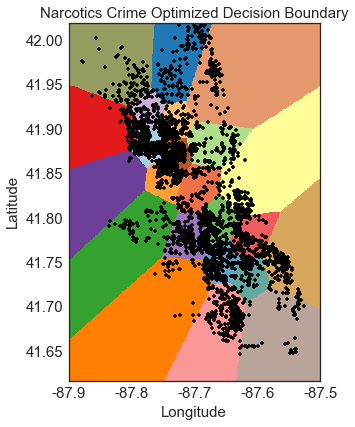

In [38]:
plt.figure(figsize=(10,15))
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .001     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = sampled_data[:, 0].min(), sampled_data[:, 0].max()
y_min, y_max = sampled_data[:, 1].min(), sampled_data[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

# plt.plot(sampled_data[:, 0], sampled_data[:, 1], 'k.', markersize=10)

plt.plot(X,Y, 'k.', markersize=7,label='Narcotics Crimes')




# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
# plt.scatter(centroids[:, 0], centroids[:, 1],
#             marker='x', s=169, linewidths=3,
#             color='w', zorder=10)


# plt.scatter(locs[:,0],locs[:,1],c='r',s=1000*g.weights_)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Narcotics Crime Optimized Decision Boundary')


# xxxx, locs = plt.xticks()
# ll=['%.1f' % a for a in xxxx]
# plt.xticks(xxxx[0::2],ll[0::2])

xtickshere=np.linspace(x_min,x_max,5)
plt.xticks(xtickshere)

xxxx, _ = plt.xticks()
ll=['%.1f' % a for a in xxxx]
plt.xticks(xxxx,ll)




ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
    
plt.grid(b=False)

# legend = plt.legend(frameon=True,prop={'size':15})
# frame = legend.get_frame()
# frame.set_facecolor('white')
# frame.set_edgecolor('black')

fig = plt.gcf()
fig.set_size_inches(4.51,6.42)
#plt.savefig('DecisionBoundary.png',dpi=300,bbox_inches='tight')

plt.show()




** Read data for current CPD locations **

In [28]:
# Read in police department locations
police_loc = pd.read_csv('Police_Stations.csv',usecols=['DISTRICT','LOCATION'])

# Extract Lat, Long
police_loc['X'] = police_loc['LOCATION'].map(lambda i: float(i.split()[-1][:-1]))
police_loc['Y'] = police_loc['LOCATION'].map(lambda i: float(i.split()[-2][1:-1]))

** Plot the result for both K-means, GMM and current CPD locations **

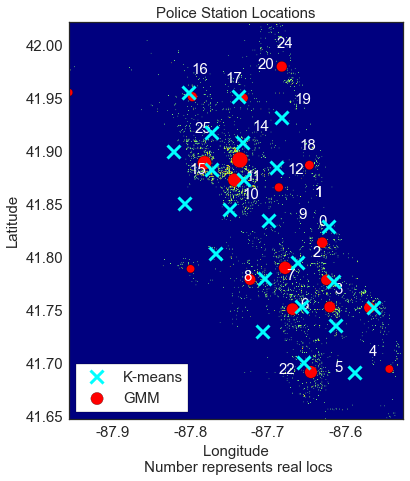

In [39]:
# Heatmap
plt.figure(figsize=(10,15))

# Heatmap
heatmap, xedges, yedges = np.histogram2d(X, Y, bins=500)
rotated = ndimage.rotate(heatmap,90,reshape=True)
rotated = np.around(rotated,5)
plt.imshow(rotated**0.2,cmap='jet', aspect=1.2,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

  
plt.scatter(centroids[:, 0], centroids[:, 1],
    marker='x', s=169, linewidths=3,
    color='cyan', zorder=10,label='K-means')

for i in xrange(len(police_loc)):
    if i == 1:
        plt.annotate(str(police_loc['DISTRICT'][i]),(police_loc['X'][i],police_loc['Y'][i]),color='w',size=15, label='Real Loc')
    plt.annotate(str(police_loc['DISTRICT'][i]),(police_loc['X'][i],police_loc['Y'][i]),color='w',size=15)

  
plt.scatter(locs[:,0],locs[:,1],c='r',s=1700*weights+50,label='GMM')

x_min, x_max = sampled_data[:, 0].min(), sampled_data[:, 0].max()
y_min, y_max = sampled_data[:, 1].min(), sampled_data[:, 1].max()


xtickshere=np.linspace(x_min,x_max,5)
plt.xticks(xtickshere)

xxxx, _ = plt.xticks()
ll=['%.1f' % a for a in xxxx]
plt.xticks(xxxx,ll)


plt.xlabel('Longitude \n Number represents real locs')
plt.ylabel('Latitude')
plt.title('Police Station Locations')

ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
    
plt.grid(b=False)
plt.ylim((yedges[0], yedges[-1]))
plt.xlim((xedges[0], xedges[-1]))
legend = plt.legend(frameon=True,prop={'size':15}, loc=3)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

fig = plt.gcf()
fig.set_size_inches(6,8)

#plt.savefig('policeloc.png',dpi=300,bbox_inches='tight')
plt.show()

**Assign a crime to a police station for the current CPD locations**

In [40]:
def respons(true_data,cluster_mean):
    
    num_samples, dim = true_data.shape

    k = cluster_mean.shape[0]
    r_n = np.zeros([num_samples,k])

    # For each sample
    for sample in xrange(num_samples):
        sqrd_two_norm = np.linalg.norm(true_data[sample,:]-cluster_mean,axis=1)**2
        closest_cluster = np.argmin(sqrd_two_norm)
        r_n[sample,closest_cluster] = 1

    return r_n

In [41]:
true_data = np.vstack((X,Y)).T
cluster_mean = np.vstack((police_loc['X'],police_loc['Y'])).T

num_samples, dim = true_data.shape

k = cluster_mean.shape[0]
r_n = respons(true_data,cluster_mean)

** Calculate the response for kmeans and GMM**

In [42]:
r_k = kmeans.predict(true_data)
r_g = EM_pred(true_data, locs, sig, weights)

In [44]:
Y_1_hot = preprocessing.OneHotEncoder(n_values=23)
r_k = Y_1_hot.fit_transform(np.reshape(r_k, (len(r_k), 1))).toarray()
r_g = Y_1_hot.fit_transform(np.reshape(r_g, (len(r_g), 1))).toarray()

In [55]:
police_locs = np.array([police_loc['X'], police_loc['Y']]).T

**Calculate the average distance from a crime site to a police station**

In [56]:
loss_g = 0.
loss_k = 0.
loss_p = 0.
for i in xrange(len(sampled_data)):
    for j in xrange(r_g.shape[1]):
        loss_g += (np.linalg.norm(true_data[i, ] - locs[j, ]))*r_g[i,j]
        loss_k += (np.linalg.norm(true_data[i, ] - kmeans.cluster_centers_[j, ]))*r_k[i,j]
        loss_p += (np.linalg.norm(true_data[i, ] - police_locs[j, ]))*r_n[i,j]
loss_g = loss_g/4999
loss_k = loss_k/4999
loss_p = loss_p/4999